In [104]:
from configobj import ConfigObj
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.interpolate import RegularGridInterpolator
import pyccl as ccl
from pyDOE2 import *
import matplotlib

#from HiCOLA import Frontend

In [139]:
def wr_funct(T_CMB):
    return 4.48150052e-7*T_CMB**4 *(1+ 3.044*7/8 * (4/11)**(4/3))

T_CMB = 2.72548 # K
print(wr_funct(T_CMB))

4.182345109176885e-05


In [174]:
# dimensionless hubble parameter in GR
def E_LCDM_calc(Omg_r,Omg_m, a):
    return np.sqrt(Omg_m/a**3 +Omg_r/a**4 + (1 - Omg_m - Omg_r))

In [149]:
def T_CMB_funct(wr):
    return (wr/4.48150052e-7/(1+ 3.044*7/8 * (4/11)**(4/3)))**0.25

print(T_CMB_funct(4.28e-5))

2.7410680712994577


In [145]:
def k_2dS_funct(f_phi,k_1dS,g_31dS,E_dS, Omg_m,Omg_r):
    return - 2*k_1dS - 12*(1-(1-f_phi)*(1-Omg_m-Omg_r)/E_dS**2)

def g_32dS_funct(f_phi,k_1dS,g_31dS,E_dS,Omg_m,Omg_r):
    k_2dS = k_2dS_funct(f_phi,k_1dS,g_31dS,E_dS,Omg_m,Omg_r)
    return 0.5 - 0.5*((1-f_phi)*(1-Omg_m-Omg_r)/E_dS**2 + k_1dS/6 + k_2dS/4 +g_31dS)


In [ ]:
''' Define useful functions'''

def create_params(f, E, h, omegas):
    '''
    Get parameters k, g from f, E and cosmo
    Inputs:
    f --> fphi
    E --> EdS
    omegas --> [b, c, r] * h^2
    
    Outputs:
    k --> k1dS
    g --> g31dS
    '''
    
    # cosmological constant density
    o_DE = h**2 - omegas[0] - omegas[1] - omegas[2]
    O_L = (1-f)*o_DE/ h**2
    
    # k and g
    alpha = 1 - O_L/E**2
    k = -6*alpha
    g = 2*alpha
    
    return k, g

print(create_params(0.42105263157894735, 1/1.4032496307237814, 0.7307, [0.02196, 0.1274, 4.28e-5]))

In [147]:
# We want Omega_m , n_s    , A_s ,h,  f_phi, EdS, k_1dS, g_31dS
sample_test = np.array([(0.1274 + 0.02196)/0.7307**2, 0.9626, 2.092e-9,0.7307, 0.42105263157894735,1/1.4032496307237814,-0.34384601713152496,-8.289986166458684])

"""
k1_parameter  = -0.34384601713152496
k2_parameter = -1.460168017955791
g31_parameter = -8.289986166458684
g32_parameter = 4.445662089077228
"""
print("k_2dS test = ",k_2dS_funct(sample_test[4],sample_test[6], sample_test[7],sample_test[5], sample_test[0],4.28e-5/sample_test[3]**2))
print("g_32dS test = ",g_32dS_funct(sample_test[4],sample_test[6], sample_test[7], sample_test[5],sample_test[0],4.28e-5/sample_test[3]**2))

print("k_2dS paper = ", -1.460168017955791)
print("g_32dS paper = ",4.445662089077228)

sample_new = sample_test#np.array([0.31966, 0.9626, 2.092e-9,0.6688, 0.42105263157894735,1/1.4032496307237814,-0.34384601713152496,-8.289986166458684])

print("k_2dS = ",k_2dS_funct(sample_new[4],sample_new[6], sample_new[7],sample_test[5], sample_new[0],wr_funct(T_CMB)/sample_new[3]**2))
print("g_32dS = ",g_32dS_funct(sample_new[4],sample_new[6], sample_new[7],sample_test[5], sample_new[0],wr_funct(T_CMB)/sample_new[3]**2))

print("f_phi = ", 0.42105263157894735)
print("E_dS = ", 1/1.4032496307237814)


k_2dS test =  -1.460168017955791
g_32dS test =  4.445662089077228
k_2dS paper =  -1.460168017955791
g_32dS paper =  4.445662089077228
k_2dS =  -1.4601429968794721
g_32dS =  4.445657918897842
f_phi =  0.42105263157894735
E_dS =  0.7126315789473684


In [136]:
## Power spectrum from CCL - backscaling

wr = 4.28e-5#wr_funct(T_CMB)

ns = sample_new[1]
As = sample_new[2]
h = sample_new[3]
wm = sample_new[0]*h**2
wb = 0.02196 * h**2

kk_ccl = np.logspace(-3,1,500)*h               # in 1/Mpc
cosmoLCDM = ccl.Cosmology(Omega_c=(wm - wb)/h**2,
                           Omega_b=wb/h**2, 
                           A_s=As, 
                           h = h,
                           n_s=ns,
                           Omega_k=0)

# Omega_g::: Note that if a non-None value is given, this may result in a physically 
# inconsistent model because the CMB temperature will still be non-zero in the parameters.
cosmoLCDM_norad = ccl.Cosmology(Omega_c=(wm - wb)/h**2,
                           Omega_b=wb/h**2, 
                           A_s=As, 
                           h = h,
                           n_s=ns,
                           Omega_k=0,
                           Omega_g = 0,
                           T_CMB = 0.0)

Pk_0 = ccl.power.linear_matter_power(cosmoLCDM, kk_ccl, 1)    # in (Mpc)^3

Growth_0 = ccl.background.growth_factor(cosmoLCDM_norad, 1)

Growth_49 = ccl.background.growth_factor(cosmoLCDM_norad, 1/(1+49))

Pk_ccl = (Growth_49/Growth_0)**2 * Pk_0*h**3    # in (Mpc)^3/h^3

kk_ccl = kk_ccl/h    # in h/Mpc
## Save power spectrum for initial conditions (Linear)

np.savetxt("/home/c2042999/PCA_project/HiCOLA_files/P_k_z.dat", np.array([kk_ccl, Pk_ccl]).T)



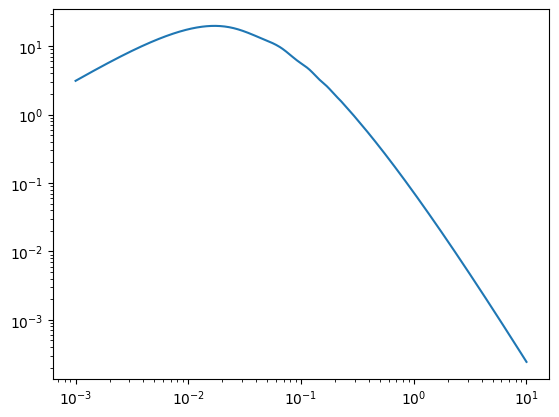

In [137]:
## Plot power spectra (at z = 49, expect very different from z=0)

plt.plot(kk_ccl,Pk_ccl)

plt.xscale("log")
plt.yscale("log")

## Get expansion and force files

In [140]:
''' Define useful functions'''

def Update_ini(run, sample, num_ini):
    """
    Updates file num_ini to include the parameters (numerical)
    """
    h = sample[3]
    wr = 4.28e-5
    wb = 0.02196
    wc = sample[0]*h**2 - wb    
    
    config_n = ConfigObj(num_ini)
    keys_n = config_n.keys()
    
    config_n[keys_n[0]] = 'run_'+str(run)
    
    config_n[keys_n[6]] = str(h)
    config_n[keys_n[7]] = str(wr)
    config_n[keys_n[8]] = str(wb)
    config_n[keys_n[9]] = str(wc)
    config_n.filename = '/home/c2042999/PCA_project/HiCOLA_files/numerical.ini'
    config_n.write()

In [141]:
Update_ini("ESS-C", sample_new, '/home/c2042999/HiCOLA_env/Cubic_galileon_emu/numerical_parameters.ini')


In [143]:
command = 'cd ; cd /home/c2042999/HiCOLA_env/Hi-COLA; python3 -m HiCOLA.Frontend.generate_simulation_input /home/c2042999/PCA_project/HiCOLA_files/horndeski_ESS-C.ini /home/c2042999/PCA_project/HiCOLA_files/numerical.ini'
os.system(command)


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/PCA_project/HiCOLA_files/horndeski_ESS-C.ini', '/home/c2042999/PCA_project/HiCOLA_files/numerical.ini'])
Horndeski functions --------------
K = X**2*k_2 + X*k_1
G_3 = X**2*g_32 + X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
ESS-C model parameters, [k_1, k_2, g_31, g_32] = [-0.34384601713152496, -1.460168017955791, -8.289986166458684, 4.445662089077228]
Cosmological parameters-----------
Omega_m0 = 0.2797409788825341
Omega_r0 = 8.016144815327033e-05
Omega_lambda0 = 0.41694565559802316
Initial conditions----------------
Hubble0 = 1.4032496307237814
scalar_prime0 = 0.9
Closure parameter is phiprime = 1.0047609090821708
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output


0

Text(0, 0.5, 'CuGal coupling $(\\beta)$')

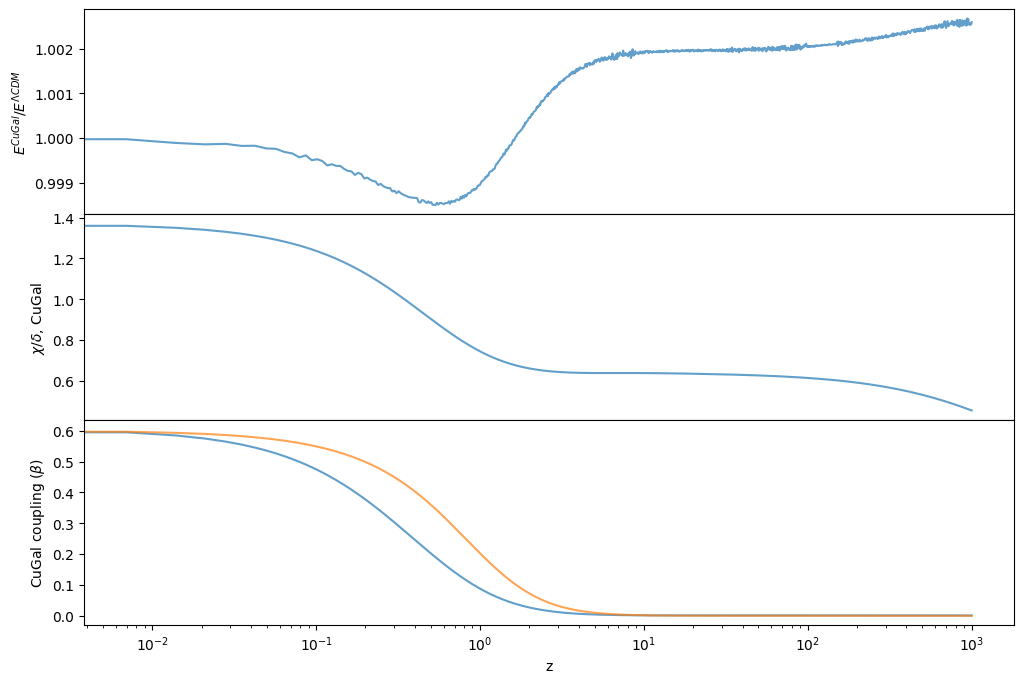

In [181]:
## Plotting ##

fig, ax = plt.subplots(3,1, figsize=(12,8),sharex=True)
fig.subplots_adjust(hspace=0,wspace=0)

# We want Omega_m*h^2 , n_s    , A_s ,h,  f_phi
expansion_today = np.loadtxt("/home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output/ESS-C_run_ESS-C_expansion.txt")

wr = 4.28e-5#wr_funct(T_CMB)
h = sample_new[3]
wm = sample_new[0]*h**2

a_today = expansion_today.T[0]
E_a_today = expansion_today.T[1]
E_a_GR = np.sqrt((wm)*a_today**(-3) + wr*a_today**(-4) + (h**2 - (wm) -wr))/h

ax[0].plot(1/a_today -1, E_a_today/E_a_GR, alpha=0.7)
#ax[0].plot(1/a_today -1, E_a_GR, alpha=0.7)

force_today = np.loadtxt("/home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output/ESS-C_run_ESS-C_force.txt")

a_today = force_today.T[0]
chiD_today = force_today.T[1] # chi/delta
coupling = force_today.T[2]

ax[1].plot(1/a_today -1, chiD_today, alpha=0.7)

ax[2].semilogx(1/a_today -1, coupling, alpha=0.7)
ax[2].semilogx(1/a_today -1, 0.6/E_LCDM_calc(wr/h**2,sample_new[0], a_today)**2, alpha=0.7)

ax[0].set_xscale("log")
ax[2].set_xlabel("z")
ax[0].set_ylabel(r"$E^{CuGal}/E^{\Lambda CDM}$")

ax[1].set_ylabel(r"$\chi/\delta$, CuGal")
ax[2].set_ylabel(r"CuGal coupling $(\beta)$")


## Rewrite Lua file

In [150]:
def rewriteluafile(k, sample,boxsize,n_particles,n_mesh):

    wb = 0.02196
    wr = 4.28e-5
    #sample = Omega_m , n_s    , A_s ,h,  f_phi, EdS, k_1dS, g_31dS, k_2dS, g_32dS
    n_s = sample[1]
    A_s = sample[2]
    h = sample[3]
    wm = sample[0]*h**2

    f_phi = sample[4]
    
    # Derived params
    Omg_r = wr/h**2
    Omg_m = wm/h**2
    Omg_b = wb/h**2
    Omg_Lambda = (1-f_phi)*(1-Omg_m-Omg_r)
    Omg_DE = (1-Omg_m-Omg_r)
    
    a= open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Hi-COLA_params_emu.lua','r')
    b = a.readlines()
    c = open('/home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_params_ESS-C_{}.lua'.format(str(k)),'w')
    for i in range(len(b)):
        if i==19:
            c.write('simulation_name = "my_new_Hi-COLA_simulation_ESS-C_{}"'.format(str(k))+'\n')
        elif i==21:
            c.write('simulation_boxsize = '+str(boxsize)+'\n')
        elif i== 40:
            c.write('cosmology_OmegaCDM = '+str((wm-wb)/h**2)+'\n')
        elif i== 42:
            c.write('cosmology_Omegab = '+str(wb/h**2)+'\n')
        elif i== 46:
            c.write('cosmology_OmegaLambda = '+str(Omg_DE)+'\n')
        elif i== 50:
            c.write('cosmology_TCMB_kelvin = '+str(T_CMB_funct(wr))+'\n')
        elif i== 52:
            c.write('cosmology_h = '+str(h)+'\n')
        elif i== 54:
            c.write('cosmology_As = '+str(A_s)+'\n')
        elif i== 56:
            c.write('cosmology_ns = '+str(n_s)+'\n')
        elif i== 63:
            c.write('  HiCOLA_expansion_filename = "/home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output/ESS-C_run_ESS-C_expansion.txt"'+'\n')
        elif i== 100:
            c.write('  HiCOLA_preforce_filename = "/home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output/ESS-C_run_ESS-C_force.txt"'+'\n')
        elif i== 208:
            c.write('particle_Npart_1D = '+str(n_particles)+'\n')
        elif i== 210:
            c.write('particle_allocation_factor = '+str(2.0)+'\n')
        elif i== 222:
            c.write('output_folder = "/home/c2042999/PCA_project/HiCOLA_files/Output_backend/COLA_{}"'.format(str(k))+'\n')
        elif i== 229:
            c.write('timestep_nsteps = {50}'+'\n')  
        elif i== 247:
            c.write('ic_random_seed ='+str(100+k)+'\n')
        elif i== 251:
            c.write('ic_fix_amplitude = true'+'\n')
        elif i== 253:
            c.write('ic_reverse_phases = false'+'\n') 
        elif i== 269:
            c.write('ic_input_filename = "/home/c2042999/PCA_project/HiCOLA_files/P_k_z.dat"'+'\n')
        elif i== 271:
            c.write('ic_input_redshift = 49.0'+'\n')
        elif i== 312:
            c.write('force_nmesh = '+str(n_mesh)+'\n')
        elif i== 345:
            c.write('pofk_nmesh = '+str(n_mesh)+'\n')
        #elif i== 359:
        #    c.write('pofk_multipole_nmesh = '+str(n_mesh)+'\n')
        #elif i== 375:
        #    c.write('bispectrum_nmesh = '+str(n_mesh)+'\n')
        else:
            c.write(b[i])

    c.close()
    a.close()


In [159]:
def rewriteluafile_phasepair(k, sample,boxsize,n_particles,n_mesh):

    wb = 0.02196
    wr = 4.28e-5
    #sample = Omega_m , n_s    , A_s ,h,  f_phi, EdS, k_1dS, g_31dS, k_2dS, g_32dS
    n_s = sample[1]
    A_s = sample[2]
    h = sample[3]
    wm = sample[0]*h**2

    f_phi = sample[4]
    
    # Derived params
    Omg_r = wr/h**2
    Omg_m = wm/h**2
    Omg_b = wb/h**2
    Omg_Lambda = (1-f_phi)*(1-Omg_m-Omg_r)
    Omg_DE = (1-Omg_m-Omg_r)
    
    a= open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Hi-COLA_params_emu.lua','r')
    b = a.readlines()
    c = open('/home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_params_ESS-C_phasepair_{}.lua'.format(str(k)),'w')
    for i in range(len(b)):
        if i==19:
            c.write('simulation_name = "my_new_Hi-COLA_simulation_ESS-C_phasepair_{}"'.format(str(k))+'\n')
        elif i==21:
            c.write('simulation_boxsize = '+str(boxsize)+'\n')
        elif i== 40:
            c.write('cosmology_OmegaCDM = '+str((wm-wb)/h**2)+'\n')
        elif i== 42:
            c.write('cosmology_Omegab = '+str(wb/h**2)+'\n')
        elif i== 46:
            c.write('cosmology_OmegaLambda = '+str(Omg_DE)+'\n')
        elif i== 50:
            c.write('cosmology_TCMB_kelvin = '+str(T_CMB_funct(wr))+'\n')
        elif i== 52:
            c.write('cosmology_h = '+str(h)+'\n')
        elif i== 54:
            c.write('cosmology_As = '+str(A_s)+'\n')
        elif i== 56:
            c.write('cosmology_ns = '+str(n_s)+'\n')
        elif i== 63:
            c.write('  HiCOLA_expansion_filename = "/home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output/ESS-C_run_ESS-C_expansion.txt"'+'\n')
        elif i== 100:
            c.write('  HiCOLA_preforce_filename = "/home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output/ESS-C_run_ESS-C_force.txt"'+'\n')
        elif i== 208:
            c.write('particle_Npart_1D = '+str(n_particles)+'\n')
        elif i== 210:
            c.write('particle_allocation_factor = '+str(2.0)+'\n')
        elif i== 222:
            c.write('output_folder = "/home/c2042999/PCA_project/HiCOLA_files/Output_backend/COLA_{}"'.format(str(k))+'\n')
        elif i== 229:
            c.write('timestep_nsteps = {50}'+'\n')  
        elif i== 247:
            c.write('ic_random_seed ='+str(100+k)+'\n')
        elif i== 251:
            c.write('ic_fix_amplitude = true'+'\n')
        elif i== 253:
            c.write('ic_reverse_phases = true'+'\n') 
        elif i== 269:
            c.write('ic_input_filename = "/home/c2042999/PCA_project/HiCOLA_files/P_k_z.dat"'+'\n')
        elif i== 271:
            c.write('ic_input_redshift = 49.0'+'\n')
        elif i== 312:
            c.write('force_nmesh = '+str(n_mesh)+'\n')
        elif i== 345:
            c.write('pofk_nmesh = '+str(n_mesh)+'\n')
        #elif i== 359:
        #    c.write('pofk_multipole_nmesh = '+str(n_mesh)+'\n')
        #elif i== 375:
        #    c.write('bispectrum_nmesh = '+str(n_mesh)+'\n')
        else:
            c.write(b[i])

    c.close()
    a.close()


In [160]:
## Create lua files

rewriteluafile(8,sample_new,400,512,1536)
# phase pair
rewriteluafile_phasepair(8,sample_new,400,512,1536)

In [157]:
"""Create P(k)"""

os.system("cd; cd /home/c2042999/HiCOLA_env/Hi-COLA/HiCOLA/FML/COLASolver; mpirun -np 32 nbody /home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_params_ESS-C_8.lua")



#=====================================================
#           ________________  .____         
#           \_   _____/     \ |    |      
#            |    __)/  \ /  \|    |      
#            |     \/    Y    \    |___   
#            \___  /\____|__  /_______ \ 
#                \/         \/        \/ 
#
# Initializing FML, MPI and FFTW
# MPI is enabled. Running with 32 MPI tasks
# OpenMP is enabled. Main task has 40 threads availiable
# MPI + Threads is working
# FFTW is enabled. Thread support is enabled
#
# List of tasks:
# Task    0 [pulsar-cn-3]
#     x-domain [       0 ,  0.03125)
# Task    1 [pulsar-cn-3]
#     x-domain [ 0.03125 ,   0.0625)
# Task    2 [pulsar-cn-3]
#     x-domain [  0.0625 ,  0.09375)
# Task    3 [pulsar-cn-3]
#     x-domain [ 0.09375 ,    0.125)
# Task    4 [pulsar-cn-3]
#     x-domain [   0.125 ,  0.15625)
# Task    5 [pulsar-cn-3]
#     x-domain [ 0.15625 ,   0.1875)
# Task    6 [pulsar-cn-3]
#     x-domain [  0.1875 ,  0.21875)
# Task    7 [pulsa

0

In [161]:
"""Create P(k) phasepair"""

os.system("cd; cd /home/c2042999/HiCOLA_env/Hi-COLA/HiCOLA/FML/COLASolver; mpirun -np 32 nbody /home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_params_ESS-C_phasepair_8.lua")



#=====================================================
#           ________________  .____         
#           \_   _____/     \ |    |      
#            |    __)/  \ /  \|    |      
#            |     \/    Y    \    |___   
#            \___  /\____|__  /_______ \ 
#                \/         \/        \/ 
#
# Initializing FML, MPI and FFTW
# MPI is enabled. Running with 32 MPI tasks
# OpenMP is enabled. Main task has 40 threads availiable
# MPI + Threads is working
# FFTW is enabled. Thread support is enabled
#
# List of tasks:
# Task    0 [pulsar-cn-3]
#     x-domain [       0 ,  0.03125)
# Task    1 [pulsar-cn-3]
#     x-domain [ 0.03125 ,   0.0625)
# Task    2 [pulsar-cn-3]
#     x-domain [  0.0625 ,  0.09375)
# Task    3 [pulsar-cn-3]
#     x-domain [ 0.09375 ,    0.125)
# Task    4 [pulsar-cn-3]
#     x-domain [   0.125 ,  0.15625)
# Task    5 [pulsar-cn-3]
#     x-domain [ 0.15625 ,   0.1875)
# Task    6 [pulsar-cn-3]
#     x-domain [  0.1875 ,  0.21875)
# Task    7 [pulsa

0

In [167]:
def rewriteluafile_GR(k, sample,boxsize,n_particles,n_mesh):
    """
    Takes in txt file with (omega_m,n_s,A_s,E_ds,f_phi) for all k
    For a certain backend file number (a certain k) it creates a lua file that makes HiCOLA output in a separate folder
    """

    wb = 0.02196
    wr = 4.28e-5
    #sample = Omega_m , n_s    , A_s ,h,  f_phi, EdS, k_1dS, g_31dS, k_2dS, g_32dS
    n_s = sample[1]
    A_s = sample[2]
    h = sample[3]
    wm = sample[0]*h**2

    f_phi = sample[4]
    
    # Derived params
    Omg_r = wr/h**2
    Omg_m = wm/h**2
    Omg_b = wb/h**2
    Omg_Lambda = (1-f_phi)*(1-Omg_m-Omg_r)
    Omg_DE = (1-Omg_m-Omg_r)
    
    a= open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Hi-COLA_params_emu.lua','r')
    b = a.readlines()
    c = open('/home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_params_GR_{}.lua'.format(str(k)),'w')
    for i in range(len(b)):
        if i==19:
            c.write('simulation_name = "my_new_Hi-COLA_simulation_GR_{}"'.format(str(k))+'\n')
        elif i==21:
            c.write('simulation_boxsize = '+str(boxsize)+'\n')
        elif i==38:
            c.write('cosmology_model = "LCDM"'+'\n')
        elif i== 40:
            c.write('cosmology_OmegaCDM = '+str((wm-wb)/h**2)+'\n')
        elif i== 42:
            c.write('cosmology_Omegab = '+str(wb/h**2)+'\n')
        elif i== 46:
            c.write('cosmology_OmegaLambda = '+str(Omg_DE)+'\n')
        elif i== 50:
            c.write('cosmology_TCMB_kelvin = '+str(T_CMB)+'\n')
        elif i== 52:
            c.write('cosmology_h = '+str(h)+'\n')
        elif i== 54:
            c.write('cosmology_As = '+str(A_s)+'\n')
        elif i== 56:
            c.write('cosmology_ns = '+str(n_s)+'\n')
        elif i== 63:
            c.write('  HiCOLA_expansion_filename = "None"'+'\n')
        elif i== 95:
            c.write('gravity_model = "GR"'+'\n')
        elif i== 100:
            c.write('  HiCOLA_preforce_filename = "None"'+'\n')
        elif i== 208:
            c.write('particle_Npart_1D = '+str(n_particles)+'\n')
        elif i== 210:
            c.write('particle_allocation_factor = '+str(2.0)+'\n')
        elif i== 222:
            c.write('output_folder = "/home/c2042999/PCA_project/HiCOLA_files/Output_backend/COLA_GR_{}"'.format(str(k))+'\n')
        elif i== 229:
            c.write('timestep_nsteps = {50}'+'\n')  
        elif i== 247:
            c.write('ic_random_seed ='+str(108)+'\n')
        elif i== 251:
            c.write('ic_fix_amplitude = true'+'\n')
        elif i== 253:
            c.write('ic_reverse_phases = false'+'\n') 
        elif i== 269:
            c.write('ic_input_filename = "/home/c2042999/PCA_project/HiCOLA_files/P_k_z.dat"'+'\n')
        elif i== 271:
            c.write('ic_input_redshift = 49.0'+'\n')
        elif i== 312:
            c.write('force_nmesh = '+str(n_mesh)+'\n')
        elif i== 345:
            c.write('pofk_nmesh = '+str(n_mesh)+'\n')
        #elif i== 359:
        #    c.write('pofk_multipole_nmesh = '+str(n_mesh)+'\n')
        #elif i== 375:
        #    c.write('bispectrum_nmesh = '+str(n_mesh)+'\n')
        else:
            c.write(b[i])

    c.close()
    a.close()


In [168]:
def rewriteluafile_GR_phasepair(k, sample,boxsize,n_particles,n_mesh):
    """
    Takes in txt file with (omega_m,n_s,A_s,E_ds,f_phi) for all k
    For a certain backend file number (a certain k) it creates a lua file that makes HiCOLA output in a separate folder
    """

    wb = 0.02196
    wr = 4.28e-5
    #sample = Omega_m , n_s    , A_s ,h,  f_phi, EdS, k_1dS, g_31dS, k_2dS, g_32dS
    n_s = sample[1]
    A_s = sample[2]
    h = sample[3]
    wm = sample[0]*h**2

    f_phi = sample[4]
    
    # Derived params
    Omg_r = wr/h**2
    Omg_m = wm/h**2
    Omg_b = wb/h**2
    Omg_Lambda = (1-f_phi)*(1-Omg_m-Omg_r)
    Omg_DE = (1-Omg_m-Omg_r)
    
    a= open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Hi-COLA_params_emu.lua','r')
    b = a.readlines()
    c = open('/home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_params_GR_phasepair_{}.lua'.format(str(k)),'w')
    for i in range(len(b)):
        if i==19:
            c.write('simulation_name = "my_new_Hi-COLA_simulation_GR_phasepair_{}"'.format(str(k))+'\n')
        elif i==21:
            c.write('simulation_boxsize = '+str(boxsize)+'\n')
        elif i==38:
            c.write('cosmology_model = "LCDM"'+'\n')
        elif i== 40:
            c.write('cosmology_OmegaCDM = '+str((wm-wb)/h**2)+'\n')
        elif i== 42:
            c.write('cosmology_Omegab = '+str(wb/h**2)+'\n')
        elif i== 46:
            c.write('cosmology_OmegaLambda = '+str(Omg_DE)+'\n')
        elif i== 50:
            c.write('cosmology_TCMB_kelvin = '+str(T_CMB)+'\n')
        elif i== 52:
            c.write('cosmology_h = '+str(h)+'\n')
        elif i== 54:
            c.write('cosmology_As = '+str(A_s)+'\n')
        elif i== 56:
            c.write('cosmology_ns = '+str(n_s)+'\n')
        elif i== 63:
            c.write('  HiCOLA_expansion_filename = "None"'+'\n')
        elif i== 95:
            c.write('gravity_model = "GR"'+'\n')
        elif i== 100:
            c.write('  HiCOLA_preforce_filename = "None"'+'\n')
        elif i== 208:
            c.write('particle_Npart_1D = '+str(n_particles)+'\n')
        elif i== 210:
            c.write('particle_allocation_factor = '+str(2.0)+'\n')
        elif i== 222:
            c.write('output_folder = "/home/c2042999/PCA_project/HiCOLA_files/Output_backend/COLA_GR_{}"'.format(str(k))+'\n')
        elif i== 229:
            c.write('timestep_nsteps = {50}'+'\n')  
        elif i== 247:
            c.write('ic_random_seed ='+str(108)+'\n')
        elif i== 251:
            c.write('ic_fix_amplitude = true'+'\n')
        elif i== 253:
            c.write('ic_reverse_phases = true'+'\n') 
        elif i== 269:
            c.write('ic_input_filename = "/home/c2042999/PCA_project/HiCOLA_files/P_k_z.dat"'+'\n')
        elif i== 271:
            c.write('ic_input_redshift = 49.0'+'\n')
        elif i== 312:
            c.write('force_nmesh = '+str(n_mesh)+'\n')
        elif i== 345:
            c.write('pofk_nmesh = '+str(n_mesh)+'\n')
        #elif i== 359:
        #    c.write('pofk_multipole_nmesh = '+str(n_mesh)+'\n')
        #elif i== 375:
        #    c.write('bispectrum_nmesh = '+str(n_mesh)+'\n')
        else:
            c.write(b[i])

    c.close()
    a.close()


In [169]:
## Create GR lua files

rewriteluafile_GR(8,sample_new,400,512,1536)
# phase pair
rewriteluafile_GR_phasepair(8,sample_new,400,512,1536)

In [170]:
"""Create P(k) GR"""

os.system("cd; cd /home/c2042999/HiCOLA_env/Hi-COLA/HiCOLA/FML/COLASolver; mpirun -np 32 nbody /home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_params_GR_8.lua")



#=====================================================
#           ________________  .____         
#           \_   _____/     \ |    |      
#            |    __)/  \ /  \|    |      
#            |     \/    Y    \    |___   
#            \___  /\____|__  /_______ \ 
#                \/         \/        \/ 
#
# Initializing FML, MPI and FFTW
# MPI is enabled. Running with 32 MPI tasks
# OpenMP is enabled. Main task has 40 threads availiable
# MPI + Threads is working
# FFTW is enabled. Thread support is enabled
#
# List of tasks:
# Task    0 [pulsar-cn-3]
#     x-domain [       0 ,  0.03125)
# Task    1 [pulsar-cn-3]
#     x-domain [ 0.03125 ,   0.0625)
# Task    2 [pulsar-cn-3]
#     x-domain [  0.0625 ,  0.09375)
# Task    3 [pulsar-cn-3]
#     x-domain [ 0.09375 ,    0.125)
# Task    4 [pulsar-cn-3]
#     x-domain [   0.125 ,  0.15625)
# Task    5 [pulsar-cn-3]
#     x-domain [ 0.15625 ,   0.1875)
# Task    6 [pulsar-cn-3]
#     x-domain [  0.1875 ,  0.21875)
# Task    7 [pulsa

0

In [171]:
"""Create P(k) phasepair GR"""

os.system("cd; cd /home/c2042999/HiCOLA_env/Hi-COLA/HiCOLA/FML/COLASolver; mpirun -np 32 nbody /home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_params_GR_phasepair_8.lua")



#=====================================================
#           ________________  .____         
#           \_   _____/     \ |    |      
#            |    __)/  \ /  \|    |      
#            |     \/    Y    \    |___   
#            \___  /\____|__  /_______ \ 
#                \/         \/        \/ 
#
# Initializing FML, MPI and FFTW
# MPI is enabled. Running with 32 MPI tasks
# OpenMP is enabled. Main task has 40 threads availiable
# MPI + Threads is working
# FFTW is enabled. Thread support is enabled
#
# List of tasks:
# Task    0 [pulsar-cn-3]
#     x-domain [       0 ,  0.03125)
# Task    1 [pulsar-cn-3]
#     x-domain [ 0.03125 ,   0.0625)
# Task    2 [pulsar-cn-3]
#     x-domain [  0.0625 ,  0.09375)
# Task    3 [pulsar-cn-3]
#     x-domain [ 0.09375 ,    0.125)
# Task    4 [pulsar-cn-3]
#     x-domain [   0.125 ,  0.15625)
# Task    5 [pulsar-cn-3]
#     x-domain [ 0.15625 ,   0.1875)
# Task    6 [pulsar-cn-3]
#     x-domain [  0.1875 ,  0.21875)
# Task    7 [pulsa

0